# Regresión lineal


Buscamos entender y predecir la relación entre dos cosas: una variable que queremos explicar (dependiente) y otras que creemos que influyen en ella (independientes).

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Resolveremos un problema de predicción de las ganancias de una empresa emergente. Tenemos los datos de 50 empresas emergentes ubicadas en Nueva York, California y Florida. La fuente de nuestros datos proviene de Kaggle

- R&D Spend: Monto que una startup gasta en I+D.
- Administration: Monto que una startup gasta en administración.
- Marketing Spend: Monto que una startup gasta en marketing.
- State: Estado en el que se encuentra ubicada. Es una variable categorica
- Profit: Ganancias de la empresa. Es nuestro label

In [64]:
dataset = pd.read_csv("50_Startups.csv")

In [65]:
dataset.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [66]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [67]:
dataset.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


# Observemos las distribuciones de las variables numéricas


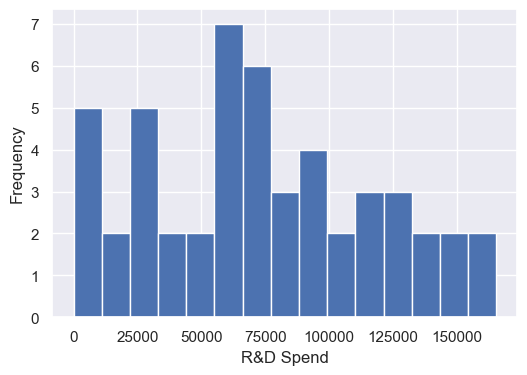

In [68]:
plt.figure(figsize=(6, 4))
dataset["R&D Spend"].hist(bins=15)
plt.xlabel("R&D Spend")
plt.ylabel("Frequency")
plt.show()

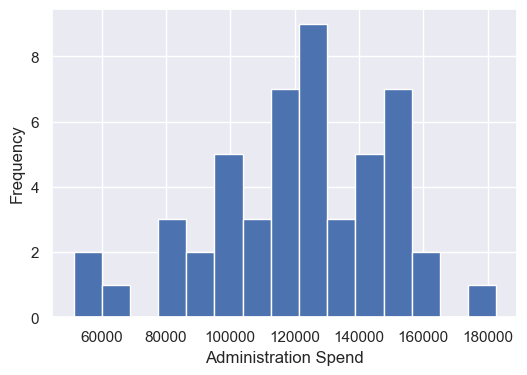

In [69]:
plt.figure(figsize=(6, 4))
dataset["Administration"].hist(bins=15)
plt.xlabel("Administration Spend")
plt.ylabel("Frequency")
plt.show()

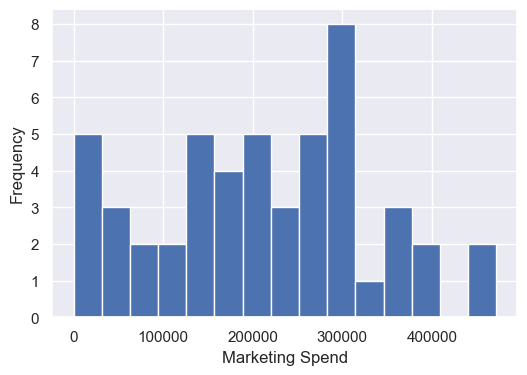

In [70]:
plt.figure(figsize=(6, 4))
dataset["Marketing Spend"].hist(bins=15)
plt.xlabel("Marketing Spend")
plt.ylabel("Frequency")
plt.show()

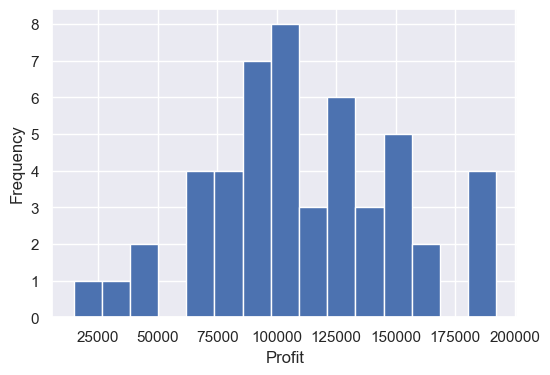

In [71]:
plt.figure(figsize=(6, 4))
dataset["Profit"].hist(bins=15)
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.show()

# ¿Y con la variable State?

In [72]:
dataset["State"].unique()

array(['New York', 'California', 'Florida'], dtype=object)

Veamos cómo se distribuyen las observaciones entre las tres ciudades:



In [73]:
dataset["State"].value_counts()


State
New York      17
California    17
Florida       16
Name: count, dtype: int64

Tenemos un problema... los modelos de regresión lineal necesitan trabajar con números, no con palabras o etiquetas.

Usamos una técnica como **One-Hot Encoding**, que convierte cada categoría en una columna nueva con valores 0 o 1.

# Variables categóricas: One-hot encoding

In [74]:
from sklearn.preprocessing import OneHotEncoder

In [75]:
# Debemos descartar una de las columnas
encoder = OneHotEncoder(drop='first')

# Configuramos el codificador con .fit()
encoder.fit(dataset[["State"]])

# Utilizamos el codificador con .transform()
encoded_state = encoder.transform(dataset[["State"]]).toarray()


In [76]:
encoded_state[:5, :]

array([[0., 1.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [77]:
encoded_columns = encoder.get_feature_names_out()
encoded_columns

array(['State_Florida', 'State_New York'], dtype=object)

Como podemos ver, nos quedamos con las categorías Florida y New York. Entonces, si tenemos el caso [0, 0], significa que la startup está en California.

Ahora, agregamos nuestras columnas a nuestro df existente

In [78]:
encoded_df = pd.DataFrame(encoded_state, columns=encoded_columns)

# Unimos las columnas codificadas con el DataFrame original con .concat()
dataset_con_dummies = pd.concat([dataset, encoded_df], axis=1)

# Eliminamos la columna 'State' con .drop()
dataset_con_dummies = dataset_con_dummies.drop(columns=["State"])

dataset_con_dummies.head()

,R&D Spend,Administration,Marketing Spend,Profit,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,0.0,1.0
1,162597.70,151377.59,443898.53,191792.06,0.0,0.0
2,153441.51,101145.55,407934.54,191050.39,1.0,0.0
3,144372.41,118671.85,383199.62,182901.99,0.0,1.0
4,142107.34,91391.77,366168.42,166187.94,1.0,0.0


# Mapa de Correlación

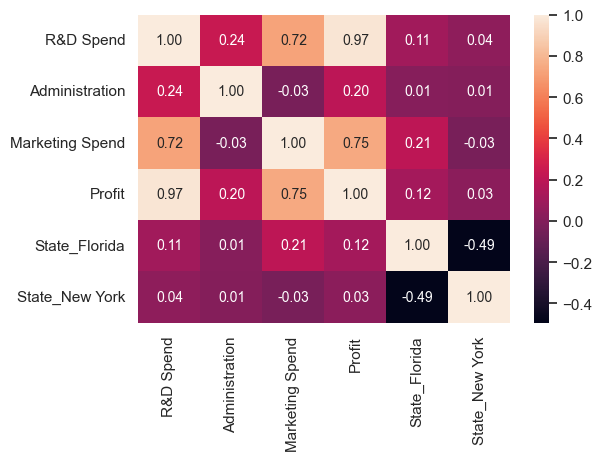

In [79]:
# Calculamos la correlación cruzada
correlacion_profit = dataset_con_dummies.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlacion_profit, annot=True, cmap='rocket', annot_kws={"size": 10}, fmt=".2f", cbar=True)
plt.show()

Entre los atributos, parece haber una correlación entre R&D Spend y Marketing Spend. Todo indica que las empresas que gastan en I+D también tienden a gastar en Marketing. Los gastos de Administration parecen no estar correlacionados con nada. Y, por último, no parece haber correlación entre los atributos y la ubicación de las startups.



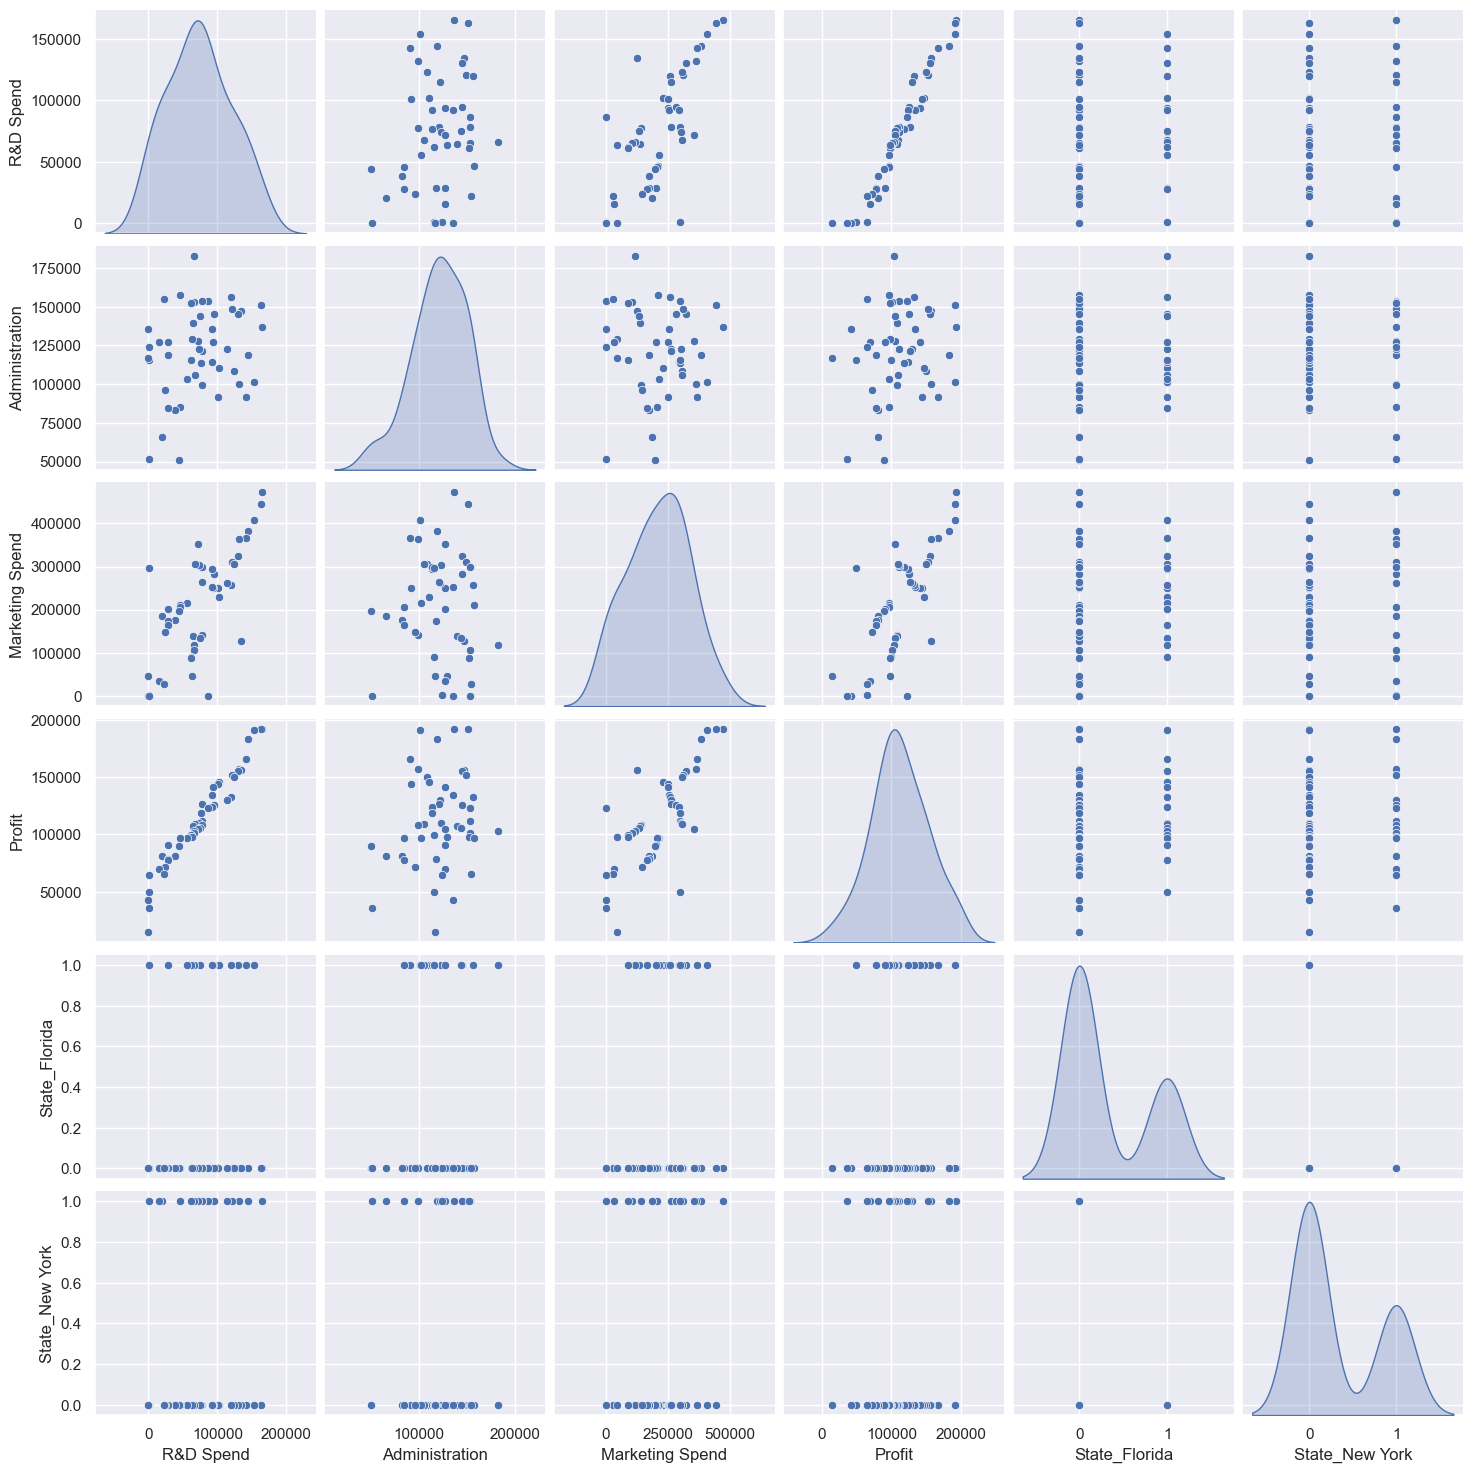

In [80]:
sns.pairplot(data=dataset_con_dummies, diag_kind="kde");

# Variables numéricas: Estandarización


Escalamos las variables para que todas tengan una misma “escala” o magnitud, lo que significa que sus valores se agrupan en torno a una media de 0 y un desvío estándar de 1. Esto es importante porque muchos modelos, como la regresión lineal, funcionan mejor o más rápido cuando todas las variables numéricas están en rangos comparables. Si una variable tiene valores mucho más grandes que las otras, puede dominar el modelo sin que eso signifique que es más importante.

Elegimos **estandarizar** cuando queremos que las variables tengan una distribución centrada en 0 y comparable en términos de variabilidad, lo cual es ideal para modelos que asumen o se ven afectados por la escala de los datos, como la regresión lineal, SVM o redes neuronales. En cambio, usamos **normalización** cuando necesitamos que los valores estén dentro de un rango fijo (como entre 0 y 1), por ejemplo, en modelos sensibles a la magnitud absoluta de los datos, en visualizaciones o cuando usamos métodos basados en distancias (como KNN o clustering) donde las diferencias entre escalas pueden distorsionar los resultados. La elección depende del modelo y del tipo de datos.

In [81]:
from sklearn.preprocessing import StandardScaler

columnas_a_escalar = ['R&D Spend', 'Administration', 'Marketing Spend']

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
valores_escalados = scaler.fit_transform(dataset_con_dummies[columnas_a_escalar])

# Crear nuevas columnas con sufijo '_scaled'
columnas_escaladas = [col + '_scaled' for col in columnas_a_escalar]
df_escalado = pd.DataFrame(valores_escalados, columns=columnas_escaladas, index=dataset_con_dummies.index)

# Concatenar al DataFrame original
df_standart = pd.concat([dataset_con_dummies, df_escalado], axis=1)

In [82]:
df_regresion = df_standart.drop(columns=['R&D Spend', 'Administration', 'Marketing Spend'])


In [83]:
df_regresion.head()

,Profit,State_Florida,State_New York,R&D Spend_scaled,Administration_scaled,Marketing Spend_scaled
0,192261.83,0.0,1.0,2.016411,0.560753,2.153943
1,191792.06,0.0,0.0,1.955860,1.082807,1.923600
2,191050.39,1.0,0.0,1.754364,-0.728257,1.626528
3,182901.99,0.0,1.0,1.554784,-0.096365,1.422210
4,166187.94,1.0,0.0,1.504937,-1.079919,1.281528


# Regresión Lineal. Modelo de predicción

In [84]:
from sklearn.metrics import  (r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

Primero, separamos el dataset entre las X y la Y

In [85]:
X = df_regresion.drop(columns='Profit')
y = df_regresion["Profit"]

Separamos el dataset en el conjunto de entrenamiento y el de evaluación, quedándonos con el 30% para el dataset de evaluación:



In [86]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Datos de train y de test
print("Dimensión de X_train:",X_train.shape)
print("Valores de y_train:",y_train.size)
print("Dimensión de X_test:",X_test.shape)
print("Valores de y_test:",len(y_test))

Dimensión de X_train: (35, 5)
Valores de y_train: 35
Dimensión de X_test: (15, 5)
Valores de y_test: 15


In [87]:
# Creamos el modelo
modelo = LinearRegression()

# Entrenamos
modelo.fit(X_train, y_train)

# Predecimos en test
y_pred = modelo.predict(X_test)

# Evaluamos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [88]:
# Mostrar coeficientes junto con los nombres de las variables
coeficientes = pd.DataFrame({'Variable': X.columns, 'Coeficiente': modelo.coef_})

print("Intercepto:", modelo.intercept_)
print(coeficientes)

Intercepto: 111603.18539341018
                 Variable   Coeficiente
0           State_Florida    458.070775
1          State_New York  -1235.156732
2        R&D Spend_scaled  36577.087510
3   Administration_scaled  -2531.142988
4  Marketing Spend_scaled   3397.859783


 Podemos ver que el atributo R&D Spend es el más relevante, seguido por Marketing Spend. Aunque el valor absoluto de Administration es más bajo respecto a los otros, que su coeficiente sea negativo es interesante, ya que indica que, cuanto más gasta una empresa en administración, menos ganancia tendrá, a diferencia de los otros dos atributos, que tienen el efecto contrario.

In [89]:
print("Coeficiente de determinación R²:", r2)

Coeficiente de determinación R²: 0.9397108063355786


R² te dice qué porcentaje de la variación del valor que querés predecir (por ejemplo, ganancias) está siendo explicado por las variables que usás en la regresió

In [90]:
print("Error cuadrático medio (MSE):", mse)

Error cuadrático medio (MSE): 84826955.03533411


**Es el promedio de los errores al cuadrado entre los valores reales y los valores predichos por tu modelo**

Cuanto más bajo, mejor es el desempeño del modelo.

Está en las unidades al cuadrado de la variable dependiente. Por ejemplo, si estás prediciendo ganancias en dólares, el MSE estará en dólares².

Para que sea más claro, usamos el RMSE, es la raíz cuadrada del MSE.

In [91]:
rmse = np.sqrt(mse)
print("Raiz de error cuadrático medio (RMSE):", rmse)

Raiz de error cuadrático medio (RMSE): 9210.154995185158


El modelo se equivoca en promedio unos 9.056 dólares al predecir el Profit (ganancia) de las startups.

Es decir, si una startup realmente obtuvo 100.000 USD de ganancia, el modelo podría estar prediciendo algo como 91.000 o 109.000 USD, en promedio.

# Regresión Logística

Tenemos el dataset de incumplimiento de clientes para una compañía de tarjetas de crédito. De cada cliente se tiene el balance que le llegó de la tarjeta, si es un estudiante universitario o no y el sueldo anual. Además contamos si el cliente incumplió el pago o no.

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
default_df = pd.read_csv("credit_data_5000.csv")

In [94]:
default_df.head()


,income,balance,student,default
0,40141.68,630.39,No,No
1,31672.97,616.05,Yes,No
2,42155.22,0.00,Yes,No
3,53829.65,675.70,Yes,No
4,30394.10,1189.85,No,Yes


In [95]:
default_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   income   5000 non-null   float64
 1   balance  5000 non-null   float64
 2   student  5000 non-null   object 
 3   default  5000 non-null   object 
dtypes: float64(2), object(2)
memory usage: 156.4+ KB


In [96]:
default_df.describe()


,income,balance
count,5000.000000,5000.000000
mean,33618.203714,839.131860
std,13177.538087,470.557206
min,800.000000,0.000000
25%,24742.520000,503.260000
50%,33696.590000,826.925000
75%,42399.582500,1162.957500
max,74000.000000,2542.410000


In [97]:
# Convertir "Yes"/"No" a 1/0 y renombrar columnas
default_df["default_n"] = default_df["default"].apply(lambda x: 1 if x == "Yes" else 0)
default_df["student_n"] = default_df["student"].apply(lambda x: 1 if x == "Yes" else 0)

# Dropear las columnas originales
default_df = default_df.drop(columns=["default", "student"])

# Ver las primeras filas para verificar
default_df.head()

,income,balance,default_n,student_n
0,40141.68,630.39,0,0
1,31672.97,616.05,0,1
2,42155.22,0.00,0,1
3,53829.65,675.70,0,1
4,30394.10,1189.85,1,0


Contamos cuando valores defaultearon

In [98]:
default_df.default_n.value_counts()


default_n
0    2642
1    2358
Name: count, dtype: int64

# Visualización

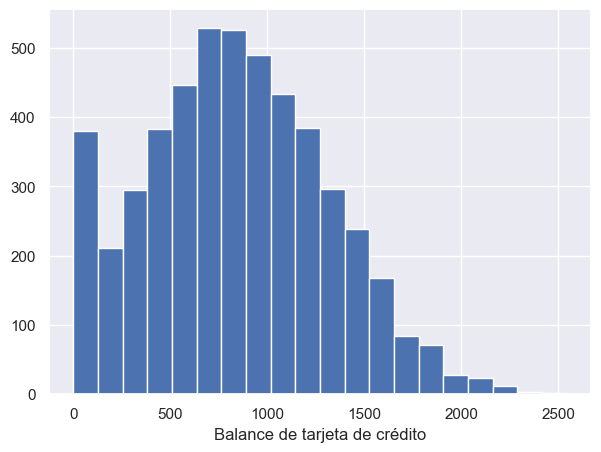

In [99]:
plt.figure(figsize=(7, 5))
default_df["balance"].hist(bins=20)
plt.xlabel("Balance de tarjeta de crédito")
plt.show()

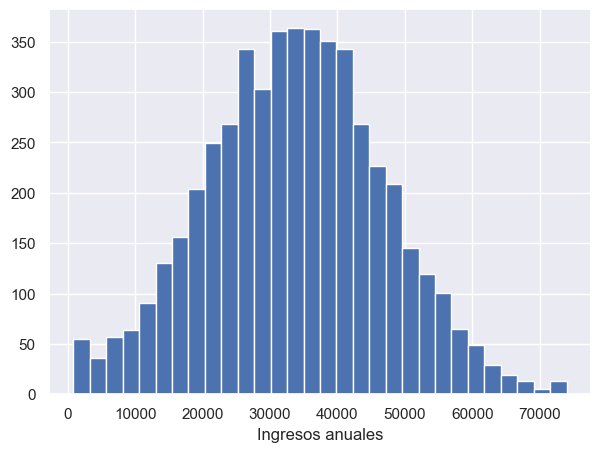

In [100]:
plt.figure(figsize=(7, 5))
default_df["income"].hist(bins=30)
plt.xlabel("Ingresos anuales")
plt.show()

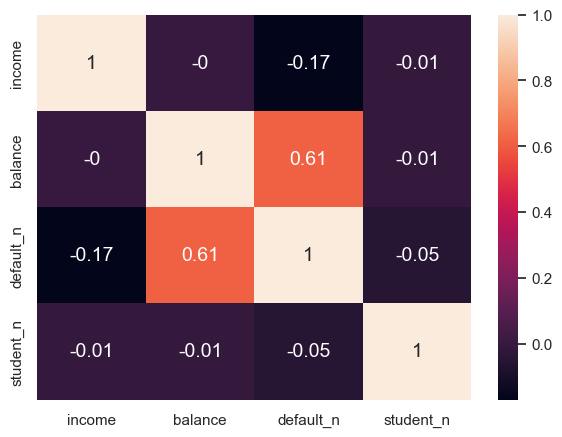

In [101]:
# Veamos la correlación cruzada
plt.figure(figsize=(7, 5))
default_profit = default_df.corr(numeric_only=True).round(2)
sns.heatmap(data=default_profit, annot=True, annot_kws={"size": 14});

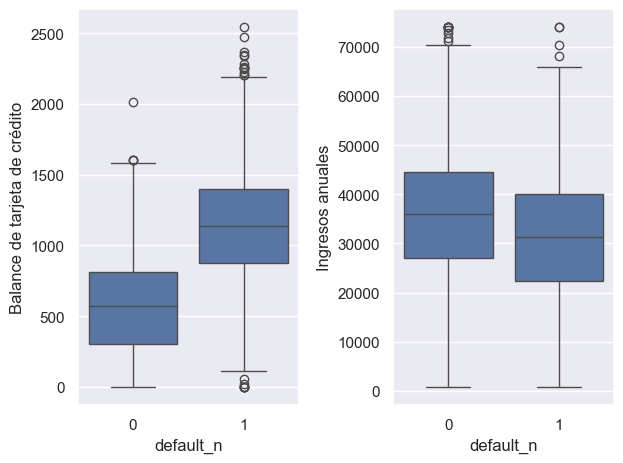

In [102]:
f, ax = plt.subplots(1,2)
sns.boxplot(data=default_df, y="balance", x="default_n", ax=ax[0])
sns.boxplot(data=default_df, y="income", x="default_n", ax=ax[1])
ax[0].set_ylabel("Balance de tarjeta de crédito")
ax[1].set_ylabel("Ingresos anuales")
plt.tight_layout();

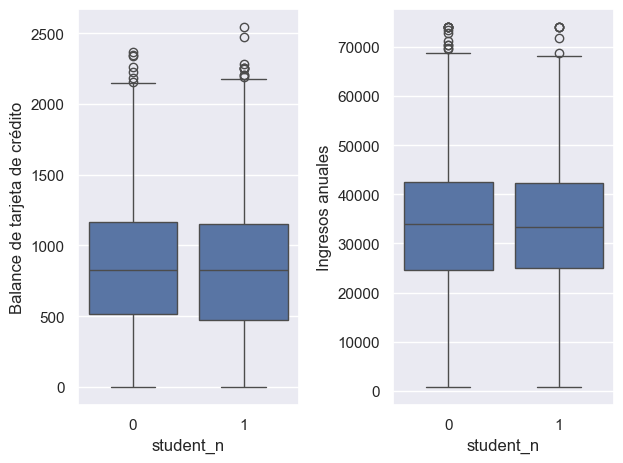

In [103]:
f, ax = plt.subplots(1,2)
sns.boxplot(data=default_df, y="balance", x="student_n", ax=ax[0])
sns.boxplot(data=default_df, y="income", x="student_n", ax=ax[1])
ax[0].set_ylabel("Balance de tarjeta de crédito")
ax[1].set_ylabel("Ingresos anuales")
plt.tight_layout();

# Modelo de Predicción. Regresión logística

In [104]:
from sklearn.preprocessing import StandardScaler

# Instanciar el escalador
scaler = StandardScaler()

# Ajustar y transformar solo las columnas numéricas
X_numeric = default_df[["income", "balance"]]
X_scaled = scaler.fit_transform(X_numeric)

# Reemplazar en el DataFrame de features, manteniendo la variable categórica codificada
X = pd.DataFrame(X_scaled, columns=["income", "balance"])
X["student_n"] = default_df["student_n"].values

In [105]:
# Verificamos media y desviación estándar de las variables escaladas
import numpy as np

print("Media de cada variable estandarizada:", np.mean(X_scaled, axis=0))
print("Desvío estándar de cada variable estandarizada:", np.std(X_scaled, axis=0))


Media de cada variable estandarizada: [3.29691829e-16 8.95283847e-17]
Desvío estándar de cada variable estandarizada: [1. 1.]


In [106]:
# Separar variables predictoras (X) y variable objetivo (y)
X = default_df[["income", "balance", "student_n"]]
y = default_df["default_n"]

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=0)

# Entrenamiento del modelo
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

# Predicciones
y_pred = modelo.predict(X_test)

# Evaluación
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy:", accuracy_score(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Matriz de confusión:
[[628 165]
 [154 553]]

Accuracy: 0.7873333333333333

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       793
           1       0.77      0.78      0.78       707

    accuracy                           0.79      1500
   macro avg       0.79      0.79      0.79      1500
weighted avg       0.79      0.79      0.79      1500



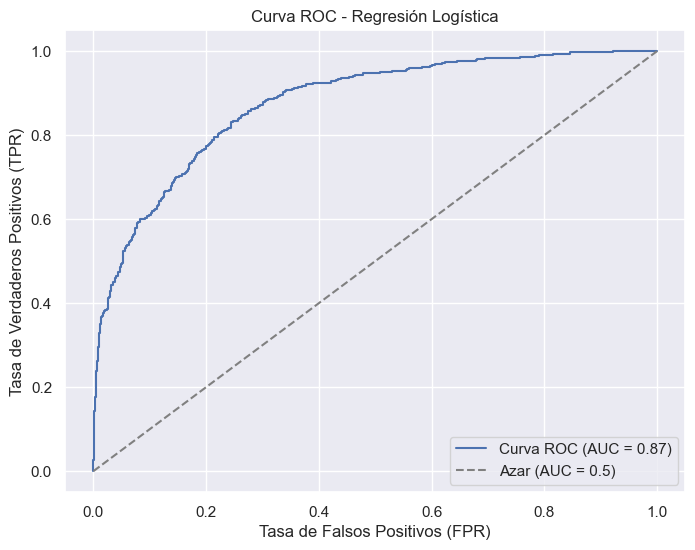

In [108]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener probabilidades de predicción
y_scores = modelo.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva

# Calcular FPR, TPR y thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calcular el AUC
auc = roc_auc_score(y_test, y_scores)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Curva ROC (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Azar (AUC = 0.5)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Regresión Logística")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()